# 自定义 SVI 目标函数


（Pyro 用 SVI 为贝叶斯推断提供支持）Pyro provides support for various optimization-based approaches to Bayesian inference, with `Trace_ELBO` serving as the basic implementation of SVI (stochastic variational inference). See the [docs](http://docs.pyro.ai/en/dev/inference_algos.html#module-pyro.infer.svi) for more information on the various SVI implementations and SVI 
tutorials [I](http://pyro.ai/examples/svi_part_i.html), 
[II](http://pyro.ai/examples/svi_part_ii.html), 
and [III](http://pyro.ai/examples/svi_part_iii.html) for background on SVI.

（本教程将用示例说明如何定制变分目标函数）In this tutorial we show how advanced users can modify and/or augment the variational objectives (alternatively: loss functions) provided by Pyro to support special use cases.

Before updated: tensor(8.5000, requires_grad=True) tensor(1., requires_grad=True)
After updated: tensor(9.0979, requires_grad=True) tensor(0.6203, requires_grad=True)
a =  9.097911834716797
b =  0.6202840209007263


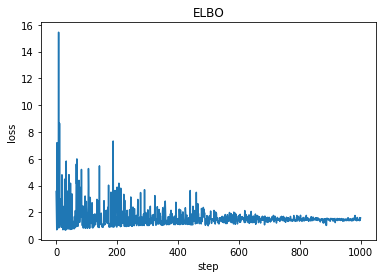

In [12]:
# 内容预告
import matplotlib.pyplot as plt
import numpy as np
import torch

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist
pyro.set_rng_seed(101)
mu = 8.5

def scale(mu):
    weight = pyro.sample("weight", dist.Normal(mu, 1.0))
    return pyro.sample("measurement", dist.Normal(weight, 0.75))
conditioned_scale = pyro.condition(scale, data={"measurement": torch.tensor(9.5)})

def scale_parametrized_guide(mu):
    a = pyro.param("a", torch.tensor(mu))
    b = pyro.param("b", torch.tensor(1.))
    return pyro.sample("weight", dist.Normal(a, torch.abs(b)))

loss_fn = pyro.infer.Trace_ELBO().differentiable_loss

pyro.clear_param_store()

with pyro.poutine.trace(param_only=True) as param_capture:
    loss = loss_fn(conditioned_scale, scale_parametrized_guide, mu)
    loss.backward()
params = [site["value"].unconstrained() for site in param_capture.trace.nodes.values()]

def step(params):
    for x in params:
        x.data = x.data - lr * x.grad
        x.grad.zero_()

print("Before updated:", pyro.param('a'), pyro.param('b'))
losses, a,b  = [], [], []
lr = 0.001
num_steps = 1000
for t in range(num_steps):
    with pyro.poutine.trace(param_only=True) as param_capture:
        loss = loss_fn(conditioned_scale, scale_parametrized_guide, mu)
        loss.backward()
        losses.append(loss.data)
    params = [site["value"].unconstrained() for site in param_capture.trace.nodes.values()]

    a.append(pyro.param("a").item())
    b.append(pyro.param("b").item())
    step(params)
print("After updated:", pyro.param('a'), pyro.param('b'))


plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");
print('a = ',pyro.param("a").item())
print('b = ', pyro.param("b").item())

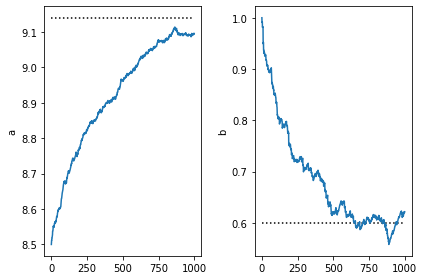

In [13]:
plt.subplot(1,2,1)
plt.plot([0,num_steps],[9.14,9.14], 'k:')
plt.plot(a)
plt.ylabel('a')

plt.subplot(1,2,2)
plt.ylabel('b')
plt.plot([0,num_steps],[0.6,0.6], 'k:')
plt.plot(b)
plt.tight_layout()

## SVI 的基本用法

我们首先回顾 Pyro 中 `SVI` objects 的使用方法. We assume that the user
has defined a `model` and a `guide`.  The user then creates an optimizer and an `SVI` object:

```python
optimizer = pyro.optim.Adam({"lr": 0.001, "betas": (0.90, 0.999)})
svi = pyro.infer.SVI(model, guide, optimizer, loss=pyro.infer.Trace_ELBO())
```

Gradient steps can then be taken with a call to `svi.step(...)`. The arguments to `step()` are then
passed to `model` and `guide`.

In [4]:
# +++++++++++ 下节预告
# 加上一个正则项
import math, os, torch, pyro
import torch.distributions.constraints as constraints
import pyro.distributions as dist
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO

assert pyro.__version__.startswith('1.3.0')
pyro.enable_validation(True)
pyro.clear_param_store()

data = []
data.extend([torch.tensor(1.0) for _ in range(6)])
data.extend([torch.tensor(0.0) for _ in range(4)])

def model(data):
    alpha0, beta0 = torch.tensor(10.0), torch.tensor(10.0)
    theta = pyro.sample("latent_fairness", dist.Beta(alpha0, beta0))
    for i in range(len(data)):
        pyro.sample("obs_{}".format(i), dist.Bernoulli(theta), obs=data[i])
def guide(data):
    alpha_q = pyro.param("alpha_q", torch.tensor(15.0), constraint=constraints.positive)
    beta_q = pyro.param("beta_q", torch.tensor(15.0), constraint=constraints.positive)
    pyro.sample("latent_fairness", dist.Beta(alpha_q, beta_q))

adam_params = {"lr": 0.0005, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params, {"clip_norm": 10.0}) # 添加梯度截断
# loss_fn = pyro.infer.Trace_ELBO().differentiable_loss # 添加正则项

svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

n_steps = 2000
for step in range(n_steps):
    svi.step(data)
    if step % 100 == 0:
        print('.', end='')

alpha_q = pyro.param("alpha_q").item()
beta_q = pyro.param("beta_q").item()
inferred_mean = alpha_q / (alpha_q + beta_q)
factor = beta_q / (alpha_q * (1.0 + alpha_q + beta_q))
inferred_std = inferred_mean * math.sqrt(factor)
print("\nbased on the data and our prior belief, the fairness " +
      "of the coin is %.3f +- %.3f" % (inferred_mean, inferred_std))

....................
based on the data and our prior belief, the fairness of the coin is 0.534 +- 0.090


## 修改损失函数

The nice thing about the above pattern is that it allows Pyro to take care of various details for us, for example:

- `pyro.optim.Adam` dynamically creates a new `torch.optim.Adam` optimizer whenever a new parameter is encountered 
- `SVI.step()` zeros gradients between gradient steps

（直接操作 loss 方法）If we want more control, we can directly manipulate the differentiable loss method of the various `ELBO` classes. For example, (assuming we know all the parameters in advance) this is equivalent to the previous code snippet:

```python
# define optimizer and loss function
optimizer = torch.optim.Adam(my_parameters, {"lr": 0.001, "betas": (0.90, 0.999)})
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
# compute loss
loss = loss_fn(model, guide, model_and_guide_args)
loss.backward()
# take a step and zero the parameter gradients
optimizer.step()
optimizer.zero_grad()
```

### 添加正则项

Suppose we want to add a custom regularization term to the SVI loss. Using the above 
usage pattern, this is easy to do. First we define our regularizer:

```python
def my_custom_L2_regularizer(my_parameters):
    reg_loss = 0.0
    for param in my_parameters:
        reg_loss = reg_loss + param.pow(2.0).sum()
    return reg_loss  
```

Then the only change we need to make is:

```diff
- loss = loss_fn(model, guide)
+ loss = loss_fn(model, guide) + my_custom_L2_regularizer(my_parameters)
```

### 梯度截断

For some models the loss gradient can explode during training, leading to overflow and 
`NaN` values. One way to protect against this is with gradient clipping. The optimizers
in `pyro.optim` take an optional dictionary of `clip_args` which allows clipping either
the gradient norm or the gradient value to fall within the given limit.

To change the basic example above:

```diff
- optimizer = pyro.optim.Adam({"lr": 0.001, "betas": (0.90, 0.999)})
+ optimizer = pyro.optim.Adam({"lr": 0.001, "betas": (0.90, 0.999)}, {"clip_norm": 10.0})
```

### Scaling the Loss

Depending on the optimization algorithm, the scale of the loss may or not matter. Suppose 
we want to scale our loss function by the number of datapoints before we differentiate it.
This is easily done:

```diff
- loss = loss_fn(model, guide)
+ loss = loss_fn(model, guide) / N_data
```

Note that in the case of SVI, where each term in the loss function is a log probability 
from the model or guide, this same effect can be achieved using [poutine.scale](http://docs.pyro.ai/en/dev/poutine.html#pyro.poutine.scale). For 
example we can use the `poutine.scale` decorator to scale both the model and guide:

```python
@poutine.scale(scale=1.0/N_data)
def model(...):
    pass
   
@poutine.scale(scale=1.0/N_data)
def guide(...):
    pass
```

### Mixing Optimizers

The various optimizers in `pyro.optim` allow the user to specify optimization settings (e.g. learning rates) on
a per-parameter basis. But what if we want to use different optimization algorithms for different parameters? 
We can do this using Pyro's `MultiOptimizer` (see below), 但是如果我们直接操作`differentiable_loss` 也可以实现相同的目的：

```python
adam = torch.optim.Adam(adam_parameters, {"lr": 0.001, "betas": (0.90, 0.999)})
sgd = torch.optim.SGD(sgd_parameters, {"lr": 0.0001})
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
# compute loss
loss = loss_fn(model, guide)
loss.backward()
# take a step and zero the parameter gradients
adam.step()
sgd.step()
adam.zero_grad()
sgd.zero_grad()
```

For completeness, we also show how we can do the same thing using [MultiOptimizer](http://docs.pyro.ai/en/dev/optimization.html?highlight=multi%20optimizer#module-pyro.optim.multi), which allows
us to combine multiple Pyro optimizers. Note that since `MultiOptimizer` uses `torch.autograd.grad` under the hood (instead of `torch.Tensor.backward()`), it has a slightly different interface; in particular the `step()` method also takes parameters as inputs.

```python
def model():
    pyro.param('a', ...)
    pyro.param('b', ...)
    ...
  
adam = pyro.optim.Adam({'lr': 0.1})
sgd = pyro.optim.SGD({'lr': 0.01})
optim = MixedMultiOptimizer([(['a'], adam), (['b'], sgd)])
with pyro.poutine.trace(param_only=True) as param_capture:
    loss = elbo.differentiable_loss(model, guide)
params = {'a': pyro.param('a'), 'b': pyro.param('b')}
optim.step(loss, params)
```

## 自定义 ELBO 损失函数


### Simple ELBO

In the previous three examples we bypassed creating a `SVI` object and directly manipulated 
the differentiable loss function provided by an `ELBO` implementation. Another thing we 
can do is create custom `ELBO` implementations and pass those into the `SVI` machinery. 
For example, a simplified version of a `Trace_ELBO` loss function might look as follows:

```python
# note that simple_elbo takes a model, a guide, and their respective arguments as inputs
def simple_elbo(model, guide, *args, **kwargs):
    # run the guide and trace its execution
    guide_trace = poutine.trace(guide).get_trace(*args, **kwargs)
    # run the model and replay it against the samples from the guide
    model_trace = poutine.trace(
        poutine.replay(model, trace=guide_trace)).get_trace(*args, **kwargs)
    # construct the elbo loss function
    return -1*(model_trace.log_prob_sum() - guide_trace.log_prob_sum())

svi = SVI(model, guide, optim, loss=simple_elbo)
```
Note that this is basically what the `elbo` implementation in ["mini-pyro"](https://github.com/pyro-ppl/pyro/blob/dev/pyro/contrib/minipyro.py) looks like.

### KL Annealing

In the [Deep Markov Model Tutorial](http://pyro.ai/examples/dmm.html) the ELBO variational objective
is modified during training. In particular the various KL-divergence terms between latent random
variables are scaled downward (i.e. annealed) relative to the log probabilities of the observed data.
In the tutorial this is accomplished using `poutine.scale`. We can accomplish the same thing by defining 
a custom loss function. This latter option is not a very elegant pattern but we include it anyway to 
show the flexibility we have at our disposal. 

```python
def simple_elbo_kl_annealing(model, guide, *args, **kwargs):
    # get the annealing factor and latents to anneal from the keyword
    # arguments passed to the model and guide
    annealing_factor = kwargs.pop('annealing_factor', 1.0)
    latents_to_anneal = kwargs.pop('latents_to_anneal', [])
    # run the guide and replay the model against the guide
    guide_trace = poutine.trace(guide).get_trace(*args, **kwargs)
    model_trace = poutine.trace(
        poutine.replay(model, trace=guide_trace)).get_trace(*args, **kwargs)
        
    elbo = 0.0
    # loop through all the sample sites in the model and guide trace and
    # construct the loss; note that we scale all the log probabilities of
    # samples sites in `latents_to_anneal` by the factor `annealing_factor`
    for site in model_trace.values():
        if site["type"] == "sample":
            factor = annealing_factor if site["name"] in latents_to_anneal else 1.0
            elbo = elbo + factor * site["fn"].log_prob(site["value"]).sum()
    for site in guide_trace.values():
        if site["type"] == "sample":
            factor = annealing_factor if site["name"] in latents_to_anneal else 1.0        
            elbo = elbo - factor * site["fn"].log_prob(site["value"]).sum()
    return -elbo

svi = SVI(model, guide, optim, loss=simple_elbo_kl_annealing)
svi.step(other_args, annealing_factor=0.2, latents_to_anneal=["my_latent"])
```